In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

##Ten Million Books

### Cleaning
####Basic Parsing

* Marc21
    * author -> 100, 110, 111
    * title -> 244a, 244b
    * pub. location -> 264a,b,c
    
####String Operations

In [2]:
import string
import unidecode
s = "Historia de la Inquisición' "
s = s.decode('utf-8')
s = unidecode.unidecode(s)
s = s.strip()
s = s.strip(string.punctuation)
s = s.lower()
s

'historia de la inquisicion'

####Geo Deduplication

* Visual inpspection
    * madrid, espana
    * madrid [espana
    * madrid (espana

In [3]:
f1 = "madrid, espana"
f2 = "madrid [espana"
f3 = "madrid (espana"
(f1.split(","), f2.split("["), f3.split("("))
# ... A few more string operations like strip for whitespace etc.

(['madrid', ' espana'], ['madrid ', 'espana'], ['madrid ', 'espana'])

In [4]:
locs = pd.read_csv("../data/locs/just_split_locs.csv")
locs = locs[["Country", "City"]].dropna(how="all")

/home/davebshow/.virtualenvs/scientific/local/lib/python2.7/site-packages/pandas/io/parsers.py:1139: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [5]:
loc_groups = locs.groupby(["City", "Country"]).groups

In [6]:
"Num. of unique country/city combinations: {0}".format(len(loc_groups))

'Num. of unique country/city combinations: 124533'

In [7]:
import operator
d = {k: len(v) for k, v in loc_groups.items()}
s = sorted(d.items(), key=operator.itemgetter(1), reverse=True)

In [8]:
"Percent of data set covered by 5000 most common combos: {0}".format(
    sum([count for loc, count in s[:5000]]) / float(len(locs)))

'Percent of data set covered by 5000 most common combos: 0.97185261794'

* The vast majority of the rest of the combinations are:
    * Impossible to deduplicate
        * Years
        * String fragments
        * Improperly labeled fields
        * ...
    * Deduplicating the 5000 most common becomes a trivial task

In [9]:
text_df = pd.read_csv("../data/geo_cleaned_texts.tsv", sep="\t")

In [11]:
clean_locs = text_df.groupby("slug")

In [14]:
counted = clean_locs.count()["control_number"]

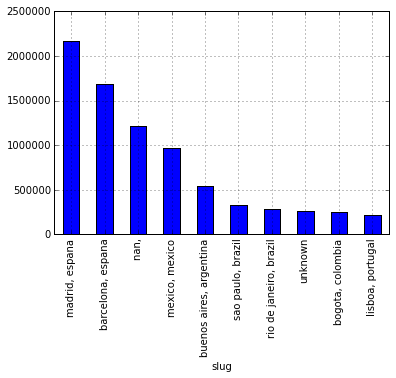

In [20]:
counted.sort(inplace=False, ascending=False).ix[:10].plot(kind="bar")

In [21]:
from fuzzywuzzy import fuzz
cerv_df = text_df[
    text_df.apply(
        lambda x: fuzz.token_set_ratio("Miguel Cervantes", x["author"]) == 100 or \
        fuzz.token_sort_ratio("Miguel Cervantes", x["author"]) > 90, axis=1)]

In [23]:
cerv_df.head(10)

,Unnamed: 0,control_number,title,uniform_title,author,publisher,pub_location,pub_year,translation,prev_language,slug,canonical_city,canonical_country
682,682,14379588,don quijote de la mancha,NaN,"cervantes saavedra, miguel de",instituto de artes graficas,barcelona,1963,NaN,NaN,"barcelona, espana",barcelona,espana
3211,3211,26175251,novelas ejemplares,NaN,"cervantes saavedra, miguel de",v. blasco ibanez,madrid,1912?-14,NaN,NaN,"madrid, espana",madrid,espana
3473,3473,277158502,el ingenioso hidalgo don quijote de la mancha,don quixote,"cervantes saavedra, miguel de",zeus,barcelona,1968,NaN,NaN,"barcelona, espana",barcelona,espana
6130,6130,431282582,novelas ejemplares,NaN,"cervantes saavedra, miguel de",juventud,barcelona,1974,NaN,NaN,"barcelona, espana",barcelona,espana
9046,9046,433771035,el casamiento enganosoy las dos doncellas,el casamiento enganoso,"cervantes saavedra, miguel de",ebro,madrid,1977,NaN,NaN,"madrid, espana",madrid,espana
9639,9639,434249007,el ingenioso hidalgo don quijote de la mancha,don quijote de la mancha,"cervantes saavedra, miguel de",gredos,madrid,d.l. 1987,NaN,NaN,"madrid, espana",madrid,espana
10281,10281,434685256,o engenhoso fidalgo d. quixote de la mancha,NaN,"cervantes saavedra, miguel de",ediclube,alfragide,1990,NaN,spa,"alfragide,",alfragide,
12670,12670,491928954,obras,NaN,"cervantes saavedra, miguel de",ediciones atlas,madrid,1945,NaN,NaN,"madrid, espana",madrid,espana
12799,12799,492758475,el ingenioso hidalgo don quijote de la mancha,NaN,"cervantes saavedra, miguel de",r. sopena,barcelona,1969,NaN,NaN,"barcelona, espana",barcelona,espana
12913,12913,493641967,obras completas de,NaN,"cervantes saavedra, miguel de",tipogr. de la revista de archivos bibliotecas ...,madrid,1923,NaN,NaN,"madrid, espana",madrid,espana


In [24]:
len(cerv_df)

13165

In [34]:
cerv_locs = cerv_df.groupby("slug")
counted_cerv_locs = cerv_locs.count()["control_number"]
counted_cerv_locs.sort(inplace=False, ascending=False).ix[:1]

slug
madrid, espana    5478
Name: control_number, dtype: int64

####Author/Text Deduplication

In [48]:
text_groups = text_df.groupby(["author", "title"]).groups

In [49]:
"Num. of unique title/author combinations: {0}".format(len(text_groups))

'Num. of unique title/author combinations: 8682520'

In [50]:
d = {k: len(v) for k, v in text_groups.items()}
s = sorted(d.items(), key=operator.itemgetter(1), reverse=True)

In [51]:
"Percent of data set covered by non-singleton combos: {0}".format(
    sum([count for loc, count in s[:2000000]]) / float(len(text_df)))

'Percent of data set covered by non-singleton combos: 0.493297250696'

In [52]:
def prob_dist(d):
    probs = {}
    for k, v in d.items():
        probs.setdefault(v, 0)
        probs[v] += 1
    return probs
probs = prob_dist(d)

In [56]:
probs.items()[5]

(6, 47136)

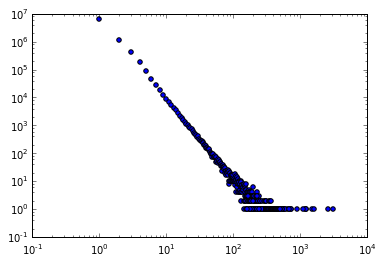

In [55]:
plt.xscale("log")
plt.yscale("log")
plt.scatter(probs.keys(), probs.values())

* Problematic!

    * El ingenioso hidalgo don Quixote de la Mancha, Cervantes, Miguel de
    * Don Quixote de la Mancha, Cervantes, Miguel de
  
    * Rimas, Lope de Vega
    * Rimas sacras, Lope de Vega
    * Rimas sacras para el ..., Lope de Vega

* String comparisons?

    * 8,682,520 * 8,682,519 / 2 = Tens of Trillions!!!!

In [58]:
num_texts = 8682520
(num_texts * (num_texts - 1)) / 2

37693072433940

* How many duplicates are there...really?

    * Visual inspection: other than title inconsistencies, data is quite well formatted.
    * Still...enter Datamade's Dedupe library.
        * Chunks of 200,000 records
        * Only about 1% are deduplicated with a confidence of over %10
        * Only about 0.1% are deduplicated with a confidence of over %50
    * However, there are duplicates, but mainly in the non-singleton texts...
    * Best method for handling this? Accept as a source of bias? Try to clean top two million...?

## Preliminaries Project

### A projected social network of Spanish Golden Age Publishing

<img src="images/minimum_tree.png">


<img src="images/we_choro.png">